<br>

# Introduction

[//]: <> (General idea of this notebook.)
This notebook facilitates using the RiverScape Python package (Straatsma and Kleinhans, 2018) to parameterize and position landscaping measures and update the input data for the two-dimensional (2D) flow model Delft3D Flexible Mesh (DFM). 

[//]: <> (Study area.)
For the current notebook version, we would use the River Waal, which is the main distributary of the River Rhine in the Netherlands.  

[//]: <> (TODO: Add Fig. 3 of Straatsma and Kleinhans, 2018)

[//]: <> (This is also a comment.)


## Requirement (python modules/packages)

To run this notebook, please import the following python modules.

In [1]:
# import standard modules
import os
import sys
import string
import subprocess
import time
import math
import pprint as pp

# import required modules/packages (which may require installation)
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import Delaunay
from shapely.geometry import MultiLineString
from shapely.ops import cascaded_union, polygonize

import matplotlib
# %matplotlib notebook
# TODO: Note that pcr.plot() still does not support interactive zoom-ing.

from collections import OrderedDict
import pcraster as pcr

<br>

Please also make sure that this notebook file is in the same folder as the RiverScape Python module files that must be loaded.

In [2]:
# check the content of this folder
!dir

# import RiverScape Python modules
import mapIO
import pcrRecipes
import measures_py3 as msr
from riverscape import *

channel.ipynb				      mapIO.py
environment.yml				      measures_py3.py
how_to_install_conda_etc.sh		      pcrRecipes.py
intervent_parameter_for_rerun_for_demo.ipynb  __pycache__
intervent_parameter.ipynb		      riverscape


In [3]:
# Most likely, you also have to fix the path. Note that pcraster must always be the first.
# TODO: Investigate why we need this? This should not happen.

fixing_path_needed = True
#fixing_path_needed = False

print(os.environ["PATH"])

if fixing_path_needed:
    os.environ["PATH"] = "/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin"
    print(os.environ["PATH"])

# test using aguila
!aguila
pcr.aguila()

/home/sutan101/opt/anaconda2/envs/rs-env\Library\bin;/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin
/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: failed to open drm device: Permission denied
libGL error: failed to load driver: i965
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast


In [4]:
# if there is any, you may want to close all aguila processes
!killall aguila

# TODO: check on windows, you may need to use 'taskkill'

<br>

# Input and output folders

In the following please define the input and output folders. 

In [5]:
# locations on fleet
input_dir    = "/home/sutan101/data/river_scape/source/from_menno/riverscape/input/"
output_dir   = "/scratch/sutan101/tmp_menno_test/out/"
scratch_dir  = output_dir + "/tmp/"

# You may also want to set the folder, interactively
# input_dir  = select_directory()
# output_dir = select_directory()

# make scratch directory and go to this folder
pcrRecipes.make_dir(scratch_dir)
os.chdir(scratch_dir)

# print some statements about the folder locations:
msg = "The input folder is set on   : " + str(input_dir)
print(msg)
msg = "The output folder is set on  : " + str(output_dir)
print(msg)
msg = "The scratch folder is set on : " + str(scratch_dir)
print(msg)

The input folder is set on   : /home/sutan101/data/river_scape/source/from_menno/riverscape/input/
The output folder is set on  : /scratch/sutan101/tmp_menno_test/out/
The scratch folder is set on : /scratch/sutan101/tmp_menno_test/out//tmp/



<br>

# Start processing/calculation 

To start processing, please load the following cells in order to set and test some basic configuration. 

<br>


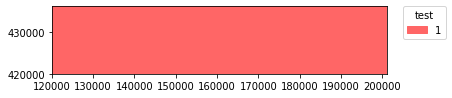

In [6]:
# go to the scratch folder
pcrRecipes.make_dir(scratch_dir)
os.chdir(scratch_dir)

# set global option for pcraster such that length of cells is computed in true length of cells
pcr.setglobaloption('unittrue')
# TODO: Check with Menno why we need this?

# set the pcraster clone map
current_dir = os.path.join(input_dir, 'reference_maps')
pcr.setclone(os.path.join(current_dir, 'clone.map'))
# check and plot the clone map
test = pcr.readmap(os.path.join(current_dir, 'clone.map'))
pcr.plot(test)
pcr.aguila(test)

In [7]:
# if there is any, you may want to close all aguila processes
!killall aguila

# TODO: check on windows, you may need to use 'taskkill'

<br>

## Loading input files

By running the following cells, the input files would be read. These input files consist of the following attributes of current/existing condition.

* main_dike: current/existing river embankment properties, e.g. length, volume and height
* minemb: minor embankment properties, e.g. length, volume and height
* groynse: groyne properties, e.g. length, volume and height
* hydro: hydrodynamics (delft3d-fm) attributes, e.g. chezy, nikuradse, specific discharge, velocity, water depth, water level, etc.
* mesh: delft3d mesh
* axis: river attributes, e.g. location, radius, turning direction, velocity, water depth, water level, etc. 
* geom: river geometry attributes, e.g. clone, dem, dist_to_main_dike, dist_to_groyne_field, dist_to_main_channel, flpl_width, flpl_narrow, flpl_wide, main_channel_width, river_side, shore_line
* lulc: land use and land cover attributes, e.g. backwaters, ecotopos, floodplain, groyne_field, main_channel, trachytopes, sections, winter_bed, real_estate_value

For further information about them, please check Menno and Kleinhans (2018), see e.g. their Table 2. 

In [22]:
# change to the 'current_dir' (input data) for reading/importing input data
os.chdir(current_dir)
!dir

#TODO: Check why do we need this? It seems that os.path.join does not work?

# reading current/existing river embankment properties for main dikes, minor embankments and groynes 
# - for each, this will return location, length, volume, and height 
main_dike = msr.read_dike_maps(current_dir, 'main_dike')
minemb    = msr.read_dike_maps(current_dir, 'minemb')
groynes   = msr.read_dike_maps(current_dir, 'groyne')

# reading Hydrodynamics (delft3d-fm) attributes 
# - chezy, nikuradse, specific discharge, velocity, water depth, water level, etc
hydro = msr.read_hydro_maps(current_dir)
# - hydrodynamic mesh
mesh = msr.read_mesh_maps(current_dir)

# reading RiverScape attributes
# - axis: location, radius, turning_direction, rkm, rkm_point, rkm_line, rkm_full
axis = msr.read_axis_maps(current_dir)
# - geometry: clone, dem, distance to main dike, distance to groyne, distance to main channel, floodplain widths, contiguous narrow floodplain, contiguous wide floodplain
geom = msr.read_geom_maps(current_dir)
# - land use land cover attributes
lulc = msr.read_lulc_maps(current_dir)

msg = "Files should be already read from: " + current_dir
print("\n")
print(msg)

axis_radius.map		  groyne_loc.map	   rkm_line.map
backwaters.map		  groyne_vol.map	   rkm_point.map
chezy.map		  legend.tmp		   sections.map
clone.map		  main_channel.map	   shore_line.map
cost_building_tot.map	  main_channel_width.map   specific_q.map
dem.map			  main_dike_height.map	   tmp.legend
dist_to_groyne_field.map  main_dike_len.map	   tmpydn8776y
dist_to_main_channel.map  main_dike_loc.map	   trachytopes.map
dist_to_main_dike.map	  main_dike_vol.map	   tributaries.map
ecotopes.map		  mask.map		   turning_direction.map
floodplain.map		  m_coor.map		   velocity.map
flpl_narrow.map		  minemb_height.map	   water_depth.map
flpl_wide.map		  minemb_len.map	   water_level.map
flpl_wide.map.aux.xml	  minemb_loc.map	   winter_bed.map
flpl_wide.map.ovr	  minemb_vol.map	   wl_exc100d.map
flpl_width.map		  n_coor.map		   wl_exc150d.map
fm_ID.map		  nikuradse.map		   wl_exc20d.map
grid_ID.map		  river_axis.map	   wl_exc2d.map
grid_ID.map.aux.xml	  river_sides.map	   wl_exc363d.map
grid_ID.



### Listing attributes/variables

After succesfully reading the files/maps, you should be able to list the attributes/variables of main_dike, minemb, groynes, hydro, mesh, axis, geom, and lulc in the following. 

In [36]:
for obj in ["main_dike", "minemb", "groynes", "hydro", "mesh", "axis", "geom", "lulc"]:
    print("\n")
    print(obj)
    print(vars()[obj].__dict__.keys())



main_dike
dict_keys(['location', 'length', 'volume', 'height'])


minemb
dict_keys(['location', 'length', 'volume', 'height'])


groynes
dict_keys(['location', 'length', 'volume', 'height'])


hydro
dict_keys(['chezy', 'nikuradse', 'specific_q', 'velocity', 'water_depth', 'water_level', 'wl_exc2d', 'wl_exc20d', 'wl_exc50d', 'wl_exc100d', 'wl_exc150d', 'wl_exc363d'])


mesh
dict_keys(['fm_ID', 'm_coor', 'n_coor', 'grid_ID'])


axis
dict_keys(['location', 'radius', 'turning_direction', 'rkm', 'rkm_point', 'rkm_line', 'rkm_full'])


geom
dict_keys(['clone', 'dem', 'dist_to_main_dike', 'dist_to_groyne_field', 'dist_to_main_channel', 'flpl_width', 'flpl_narrow', 'flpl_wide', 'main_channel_width', 'river_side', 'shore_line'])


lulc
dict_keys(['backwaters', 'ecotopes', 'floodplain', 'groyne_field', 'main_channel', 'trachytopes', 'sections', 'winter_bed', 'real_estate_value'])


### Visualizing existing attributes

You may want to check existing attributes by plotting them. Some examples are given in the following cells.

In [39]:
# go to the scratch directory so that all temporary files (e.g. made during aguila) would be stored there 
os.chdir(scratch_dir)

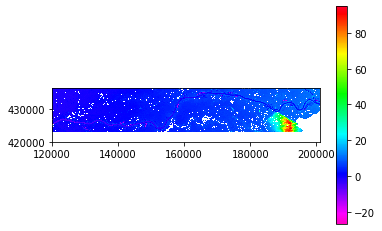

In [40]:
# plot digital elevation model
pcr.aguila(geom.dem)
pcr.plot(geom.dem)

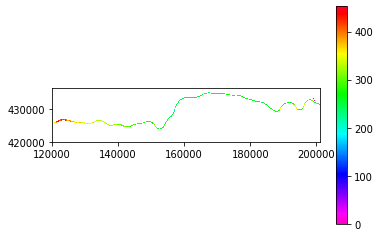

In [41]:
# plot river main channel width
pcr.aguila(geom.main_channel_width)
pcr.plot(geom.main_channel_width)

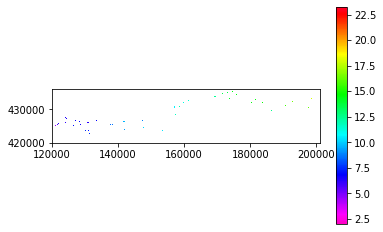

In [69]:
# plot height of main_dike
pcr.aguila(main_dike.height)
pcr.plot(main_dike.height)

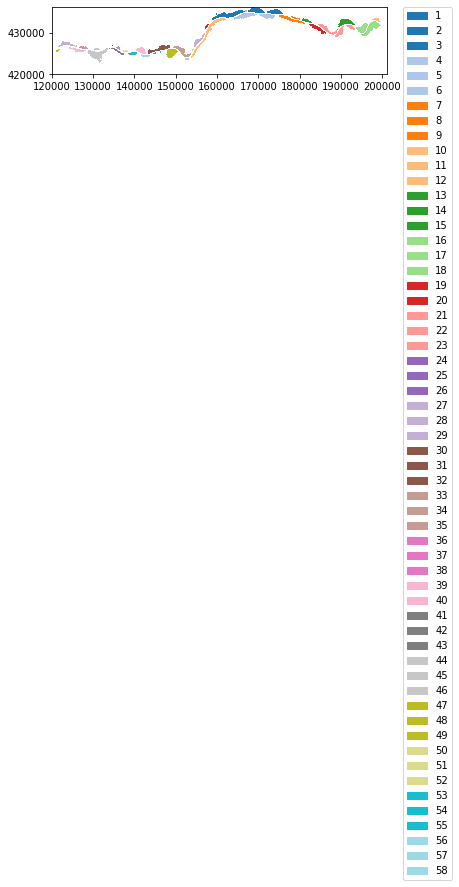

In [77]:
# plot flpl_wide IDs
pcr.aguila(geom.flpl_wide)
pcr.plot(geom.flpl_wide)

<br>

## Initiating the River and Its Measures

Given the aforementioned attributes, the River Waal and its current measured would be initiated by executing the following cells. 


In [42]:
# The River Wall is initiated based on the aforementioned given attributes.
waal = msr.River('Waal', axis, main_dike, minemb, groynes, hydro, 
                         mesh, lulc, geom)

In [43]:
# Initiate the Measures for the River.
waal_msr = msr.RiverMeasures(waal)

<br>

# Configuration for the Measures

The following properties are the default/setting configuration to the Measures.

In [44]:
# Default setting/configuration to the Measures.
settings = OrderedDict([
                    ('smoothing_percentage', 100),
                    ('smoothing_ecotope', 'UG-2'),
                    ('smoothing_trachytope', 1201),
                    
                    ('lowering_percentage', 100),
                    ('lowering_ecotope', 'UG-2'),
                    ('lowering_trachytope', 1201),
                    ('lowering_height', 'water_level_50d'),
                    
                    ('channel_width', 75),
                    ('channel_depth', 2.5),
                    ('channel_slope', 1./3.),
                    ('channel_ecotope', 'RnM'),
                    ('channel_trachytope', 105),
                    
                    ('relocation_alpha', 10000),
                    ('relocation_depth', 'AHN'),
                    ('relocation_ecotope', 'HG-2'),
                    ('relocation_trachytope', 1201),
                    
                    ('groyne_ref_level', 'wl_exc150d'),
                    ('minemb_ref_level', 'wl_exc50d'),
                    ('main_dike_dh', 0.50),
                    ])

# Put the default setting/configuration to the Measures. 
waal_msr.settings = settings

As as an initial default setting, measures will be set everywhere.

In [70]:
mask = pcr.boolean(1)
label = 'everywhere'

<br>

## Side channel measure:



### Make your own side channel properties:

You may want to modify the side channel properties using the followong interactive cell.

In [78]:
channel_values = channel_properties()

interactive(children=(IntSlider(value=50, description='Width [m]', max=200, min=5, step=5), FloatSlider(value=…

Load the following cell to use your configuration.

In [79]:
settings['channel_width'] = channel_values.kwargs['width']
settings['channel_depth'] = channel_values.kwargs['depth']
settings['channel_slope'] = channel_values.kwargs['slope']
pp.pprint(settings)
waal_msr.settings = settings

OrderedDict([('smoothing_percentage', 100),
             ('smoothing_ecotope', 'UG-2'),
             ('smoothing_trachytope', 1201),
             ('lowering_percentage', 100),
             ('lowering_ecotope', 'UG-2'),
             ('lowering_trachytope', 1201),
             ('lowering_height', 'water_level_50d'),
             ('channel_width', 50),
             ('channel_depth', 1.0),
             ('channel_slope', 2),
             ('channel_ecotope', 'RnM'),
             ('channel_trachytope', 105),
             ('relocation_alpha', 10000),
             ('relocation_depth', 'AHN'),
             ('relocation_ecotope', 'HG-2'),
             ('relocation_trachytope', 1201),
             ('groyne_ref_level', 'wl_exc150d'),
             ('minemb_ref_level', 'wl_exc50d'),
             ('main_dike_dh', 0.5),
             ('msr_type', 'sidechannel'),
             ('ID', 'edwin_sections')])



### Selecting the mask/region:

Please define the mask/area where you want to put this measure. Please also give a label for this measure.

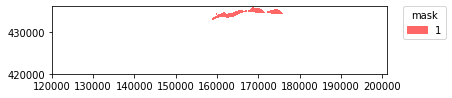

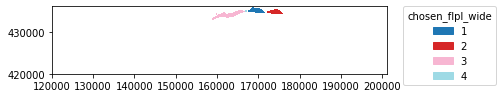

In [81]:
# Default mask and label
label = 'everywhere'
mask = pcr.boolean(1)

# TODO: Make interactive input for selecting mask for every measure.

# - some examples to select a limited mask region

label = "large_sections"
mask = pcr.ifthen(pcr.areaarea(waal.geom.flpl_wide) > 1e6, pcr.boolean(1.0))

# -- this will return floodplain with IDs < 5 
label = "edwin_sections"
mask = pcr.ifthen(pcr.scalar(waal.geom.flpl_wide) < 5, pcr.boolean(1.0))

# - plot the chosen mask
pcr.aguila(mask)
pcr.plot(mask)
chosen_flpl_wide = pcr.ifthen(mask, waal.geom.flpl_wide)
pcr.aguila(chosen_flpl_wide)
pcr.plot(chosen_flpl_wide)

In [83]:
# close all aguila processes 
!killall aguila

aguila: no process found



### Implementing the measure

By running the following cell, the measure will be implemented.

In [84]:
# measure by side channel constrcution
# - this includes looping over flood plain IDs
chan_msr = waal_msr.side_channel_measure(settings, mask = mask, ID = label)

[1, 2, 3]
1
2
3



### Exploring the measure

You can explore the measure implemented by running the following plotting cell.

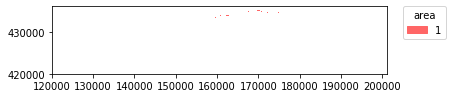

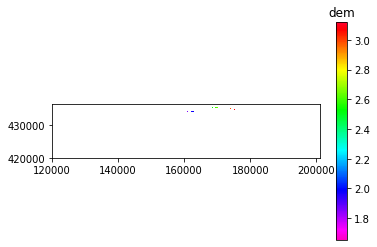

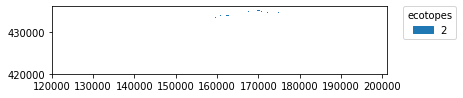

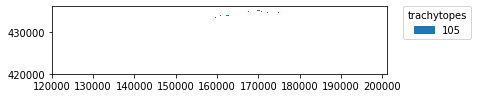

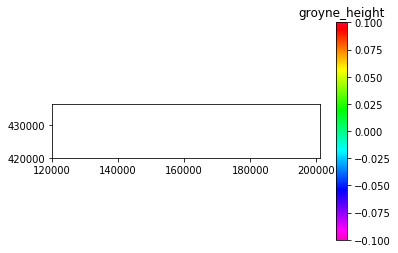

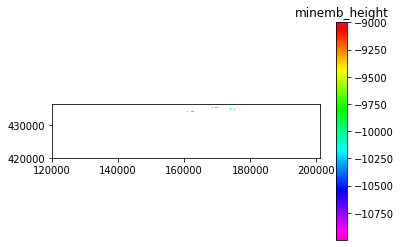

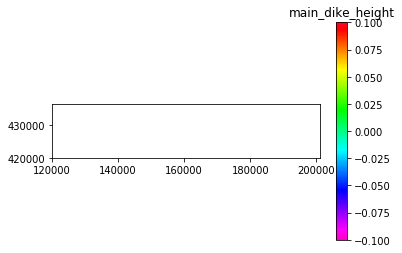

In [86]:
# plot/explore side channel measure
chan_msr.plot()

<br>

Please define the mask/area where you want to put this measure. Please also give a label for this measure.

<br>

## Flood plain lowering measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [87]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [88]:
# floodplain lowering measure
lowering_msr = waal_msr.lowering_measure(settings, mask=mask, ID=ID)

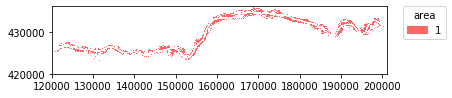

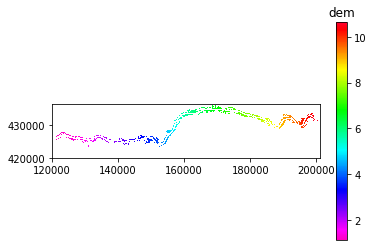

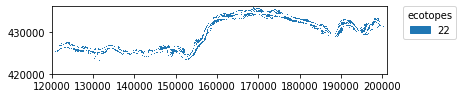

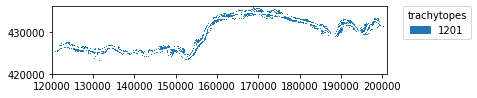

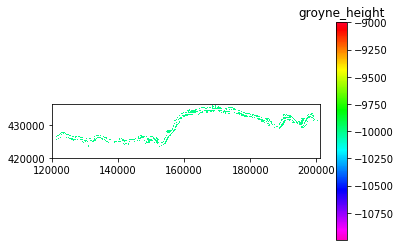

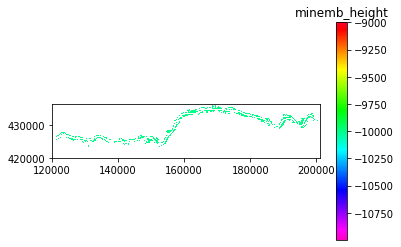

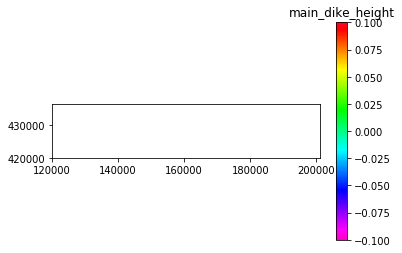

In [89]:
# plot/explore floodplain lowering measure
lowering_msr.plot()

In [90]:
# close all aguila processes 
!killall aguila

<br>

## Groyne lowering measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [91]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [92]:
# groyne lowering measure
groyne_low_msr = waal_msr.groyne_lowering_msr(settings, mask=mask, ID=ID)

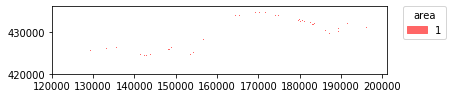

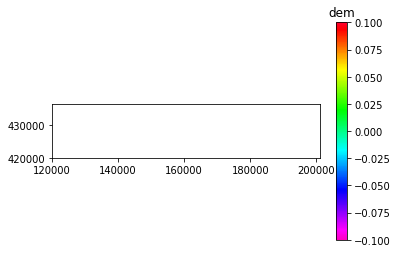

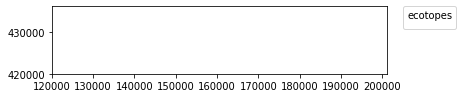

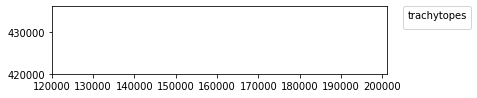

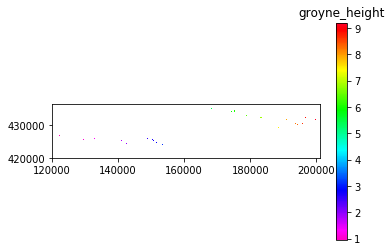

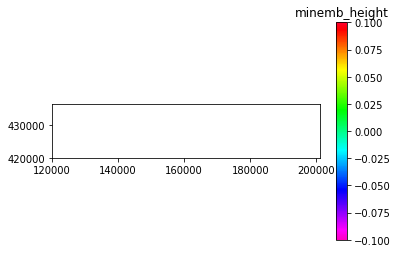

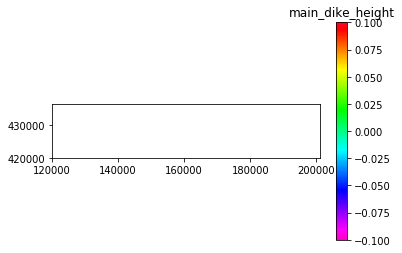

In [93]:
# plot/explore groyne lowering measure
groyne_low_msr.plot()

In [94]:
# close all aguila processes 
!killall aguila

<br>

## Minor embankment lowering measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [95]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [96]:
# measure by minor embankment lowering
minemb_low_msr = waal_msr.minemb_lowering_msr(settings, mask=mask, ID=ID)

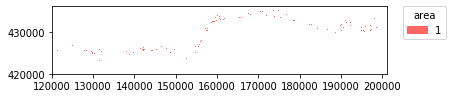

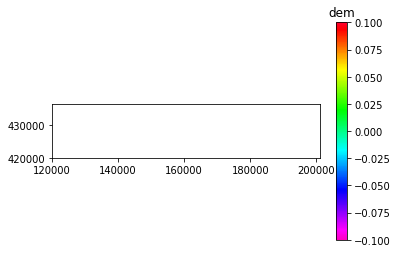

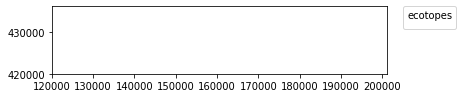

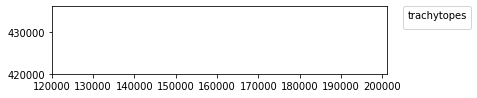

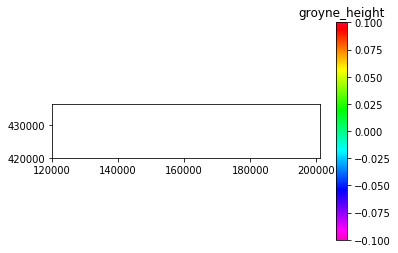

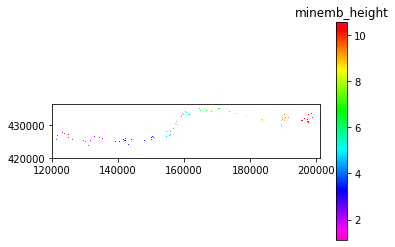

In [ ]:
# plot/explore minor embankment lowering
minemb_low_msr.plot()

In [ ]:
# close all aguila processes 
!killall aguila

<br>

## Main dike raising measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [ ]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [ ]:
# measure by main dike raising
main_dike_raise_msr = waal_msr.main_dike_raising_msr(settings, mask=mask, ID=ID)

In [ ]:
# plot/explore main dike raising measure
main_dike_raise_msr.plot()

In [ ]:
# close all aguila processes 
!killall aguila

<br>

## Roughness smoothing measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [ ]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [ ]:
# measure by roughness smoothing
smooth_msr = waal_msr.smoothing_measure(settings, mask=mask, ID=ID)

In [ ]:
# plot/explore measure by roughness smoothing
smooth_msr.plot()

In [ ]:
# close all aguila processes 
!killall aguila

Saving measures to the disk
========================

In [ ]:
# list of measures
msr_list = [groyne_low_msr, minemb_low_msr,
            main_dike_raise_msr, lowering_msr, chan_msr, smooth_msr]
# - preparing the directory
msr_root_dir = os.path.join(output_dir, 'measures_ensemble/maps')
pcrRecipes.make_dir(msr_root_dir)
for measure in msr_list:
    msr.write_measure(measure, msr_root_dir)